# Customer Behavior Analysis: It’s Always About the Customer

<!-- ![pic]("image/Manta_inspiration.jpg") -->
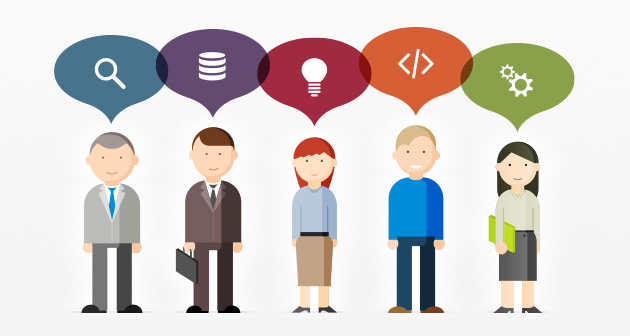

# Introduction

Day by day, there are a multitude of decisions that companies have to face. With the help of cohort analysis, we are going to be able to support the company to gain customers, boost profits, and save your budget based on data, not the gut feeling.

In this project, we will start off examining the sales trend and customer behavior pattern in exploratory data analysis, and then proceed to retention analysis and average spending across cohorts. Finally, I will finish up by calculating the customer lifetime value to identify those top customers that the company should maintain the relationship with to ensure continuous revenue.

# Import module

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import calendar
import warnings
pd.set_option('display.max.rows', 500)

# Load data

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [2]:
# Read in the data
online_raw = pd.read_excel('Online Retail.xlsx')

# Data Preprocessing

The missing values in the data set:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


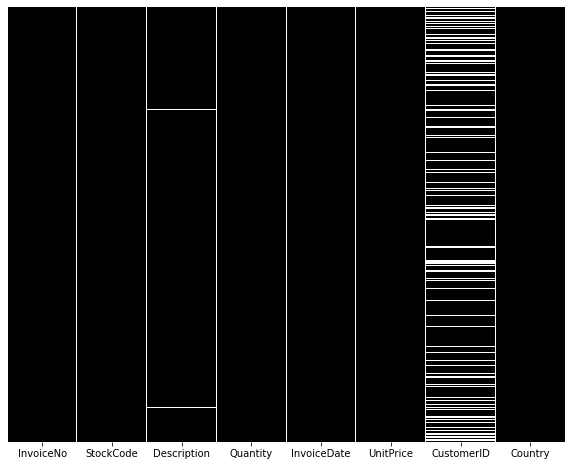

In [4]:
# Check the missing values
print(f'The missing values in the data set:\n{online_raw.isnull().sum()}')
plt.subplots(figsize=(10, 8))
sns.heatmap(online_raw.isnull(), yticklabels = False,cbar = False, cmap='cubehelix')
plt.show()

In [6]:
warnings.filterwarnings("ignore")
# Drop the entries with no customer id 
online_df = online_raw[online_raw.CustomerID.notnull()]

# Keep only the date information
online_df['InvoiceDate'] = pd.to_datetime(online_df['InvoiceDate'].dt.date)

# Keep only the complete months
online_df = online_df[(online_df['InvoiceDate'] >= '2011-01-01') & (online_df['InvoiceDate'] < '2011-12-01')]  

In [7]:
# Save the cancelled trasactions to a new data frame
cancelled_df = online_df[online_df["InvoiceNo"].astype(str).str.contains("C", na=False)]

# Remove cancelled transactions
online_df = online_df[~online_df["InvoiceNo"].astype(str).str.contains("C", na=False)]

# Remove unreasonable entries and drop duplicates
online_df = online_df[(online_df['Quantity'] > 0) & (online_df['UnitPrice'] > 0) & (online_df['CustomerID'].notnull())]\
                .drop_duplicates()

# Perform a simple feature engineering
online_df['Year'] = online_df['InvoiceDate'].dt.year
online_df['Month'] = online_df['InvoiceDate'].dt.month
online_df['DayOfWeek'] = online_df['InvoiceDate'].dt.day_name()
online_df['Revenue'] = online_df['Quantity'] * online_df['UnitPrice']
online_df = online_df[online_df['Country'] == 'United Kingdom']
print(f'After initial preprocessing, now we have {online_df.shape[0]} rows and {online_df.shape[1]} columns in the data')

After initial preprocessing, now we have 310221 rows and 12 columns in the data


# Exploratory data analysis

In [9]:
def plot_style_setting(figsize=[10, 6]):
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['axes.labelpad'] = 10
    plt.rcParams['axes.grid.axis'] = 'y'
    plt.style.use('seaborn-whitegrid')
#     plt.rcParams['font.sans-serif'] = "monospace"
    plt.rcParams['font.family'] = "monospace"
    params = {i:'#595959' for i in ["axes.titlecolor", "ytick.color", "xtick.color","axes.labelcolor","text.color"]}
    plt.rcParams.update(params)

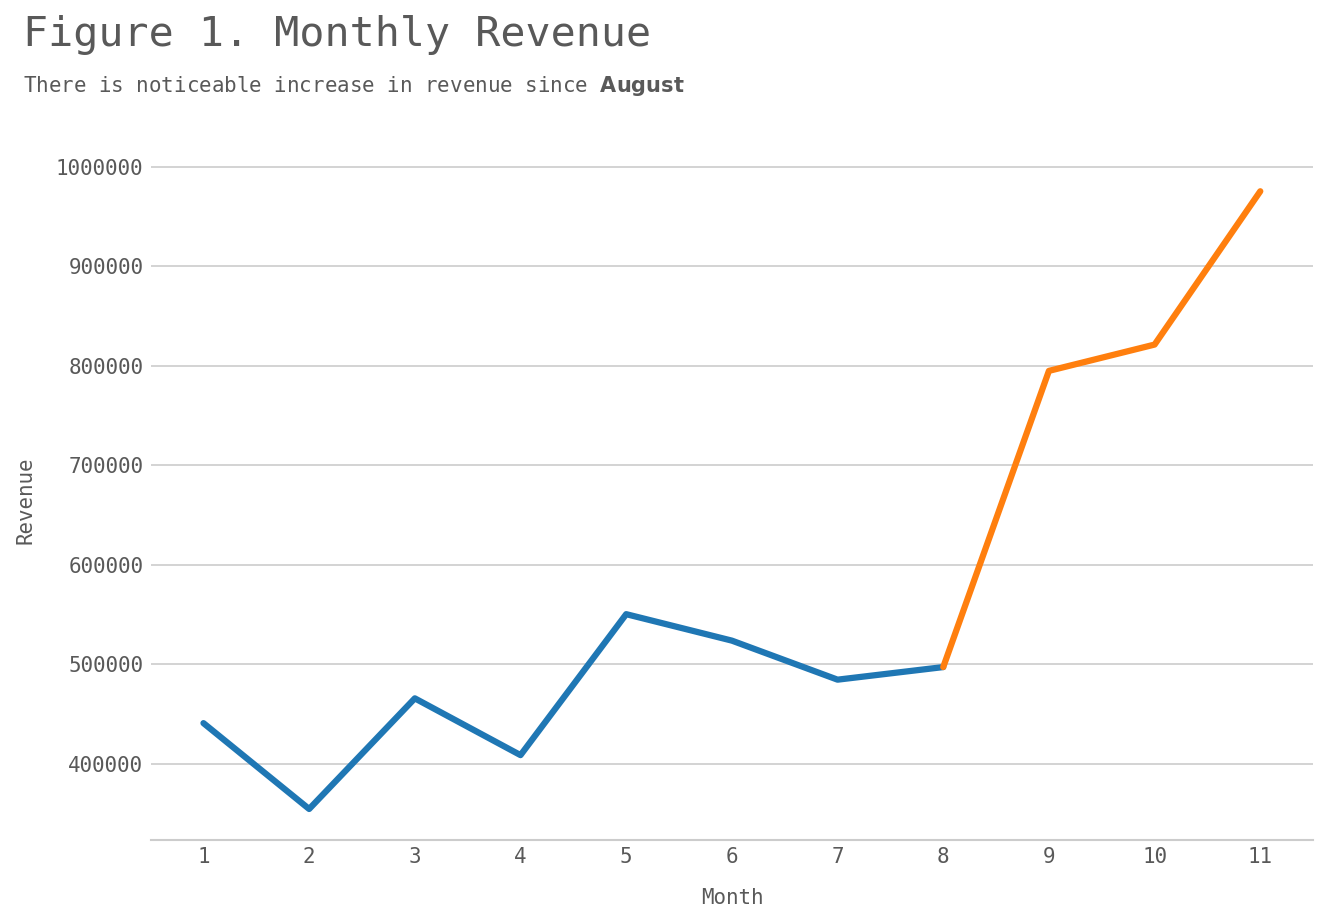

In [11]:
# Monthly Revenue Overview
revenue_df = online_df.groupby(["Year", "Month"])["Revenue"].sum().reset_index()

plot_style_setting()
g1 = sns.lineplot(x="Month", 
                 y="Revenue", 
                 lw=3, 
                 palette = ['#595959'],
                 data=revenue_df.iloc[:8,:])

g2 = sns.lineplot(x="Month", 
                 y="Revenue", 
                 lw=3, 
                 data=revenue_df.iloc[7:,:])
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
g2.yaxis.set_major_formatter(formatter)

plt.title(f'Figure 1. Monthly Revenue', 
          fontsize=20, 
          loc='left',
          x=-0.11,
          y=1.15)
g2_bold = r"$\bf{" + str('August') + "}$"
plt.text(-0.11, 1.1, 
         f'There is noticeable increase in revenue since {g2_bold}', 
         transform=g2.transAxes)

plt.xlabel("Month")
plt.ylabel("Revenue")
g2.set_xticks(revenue_df.iloc[:, 1])
sns.despine(left=True)


Revenue skyrocketed since August with the all months before it remaining relatively flat. Since this is a monthly data in 2011, we can't rule out the possibility that this is due to seasonality. But considering the extent of growth, I would guess the phenomenon is caused by the implementation of a new marketing strategy. In the following analysis, I would dig deeper into the composition of the customer base while at the same time looking for the main drive behind the revenue boost from August to November.

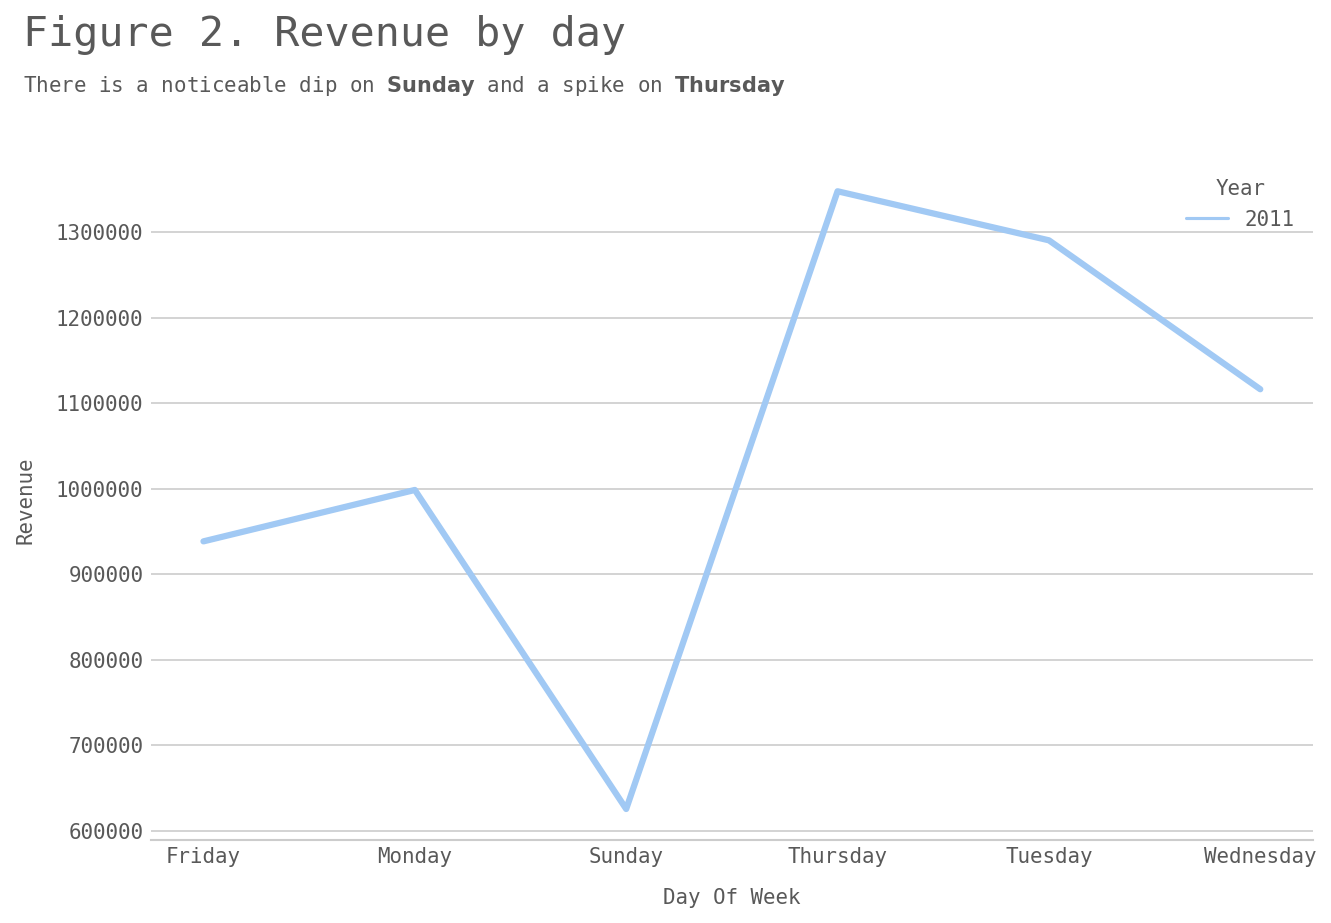

In [12]:
# Purchase Day Overview
DayOfWeek_df = online_df.groupby(["Year", "DayOfWeek"])["Revenue"].sum().reset_index()

g3 = sns.lineplot(x="DayOfWeek", 
                 y="Revenue", 
                 hue="Year", 
                 lw=3, 
                 markers=True,
                 dashes=False, 
                 palette = 'pastel',
                 data=DayOfWeek_df)

formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
g3.yaxis.set_major_formatter(formatter)

plt.title(f'Figure 2. Revenue by day', 
          fontsize=20, 
          loc='left',
          x=-0.11,
          y=1.15)
g3_bold1 = r"$\bf{" + str('Sunday') + "}$"
g3_bold2 = r"$\bf{" + str('Thursday') + "}$"
plt.text(-0.11, 1.1, 
         f'There is a noticeable dip on {g3_bold1} and a spike on {g3_bold2}', 
         transform=g3.transAxes)

plt.xlabel("Day Of Week")
plt.ylabel("Revenue")


sns.despine(left=True)


## Customer base formation & analysis

### New customers VS Repeat customers

In [13]:
# Define a function that will parse the first day of each month
def get_day(x): return dt.datetime(x.year, x.month, 1) 

# Create InvoiceDay column
online_df['InvoiceDay'] = online_df['InvoiceDate'].apply(get_day) 

# Create a column that records the first month a customer purchase from the store 
online_df['FirstPurchMonth'] = online_df.groupby('CustomerID')['InvoiceDay'].transform('min')

# Create a column that records the last month a customer purchase from the store 
online_df['LastPurchMonth'] = online_df.groupby('CustomerID')['InvoiceDay'].transform('max')

# Create a column that records the last month a customer purchase from the store 
online_df['DurationMonth'] = online_df["LastPurchMonth"].dt.to_period("M") - online_df["FirstPurchMonth"].dt.to_period("M")
online_df["DurationMonth"] = online_df["DurationMonth"].map(lambda x: x.n) 

# Active customers per month 
monthly_cus_df = online_df.groupby('InvoiceDay', as_index=False)['CustomerID']\
                          .nunique()\
                          .rename({'CustomerID': 'TotalCustomers'}, axis=1)

# Separate new customers and exsisting customers 
monthly_cus_df['NumberOfNewCustomers'] = online_df.groupby('FirstPurchMonth')['CustomerID'].nunique().tolist()
monthly_cus_df['NumberOfRepeatCustomers'] = monthly_cus_df['TotalCustomers'] - monthly_cus_df['NumberOfNewCustomers']

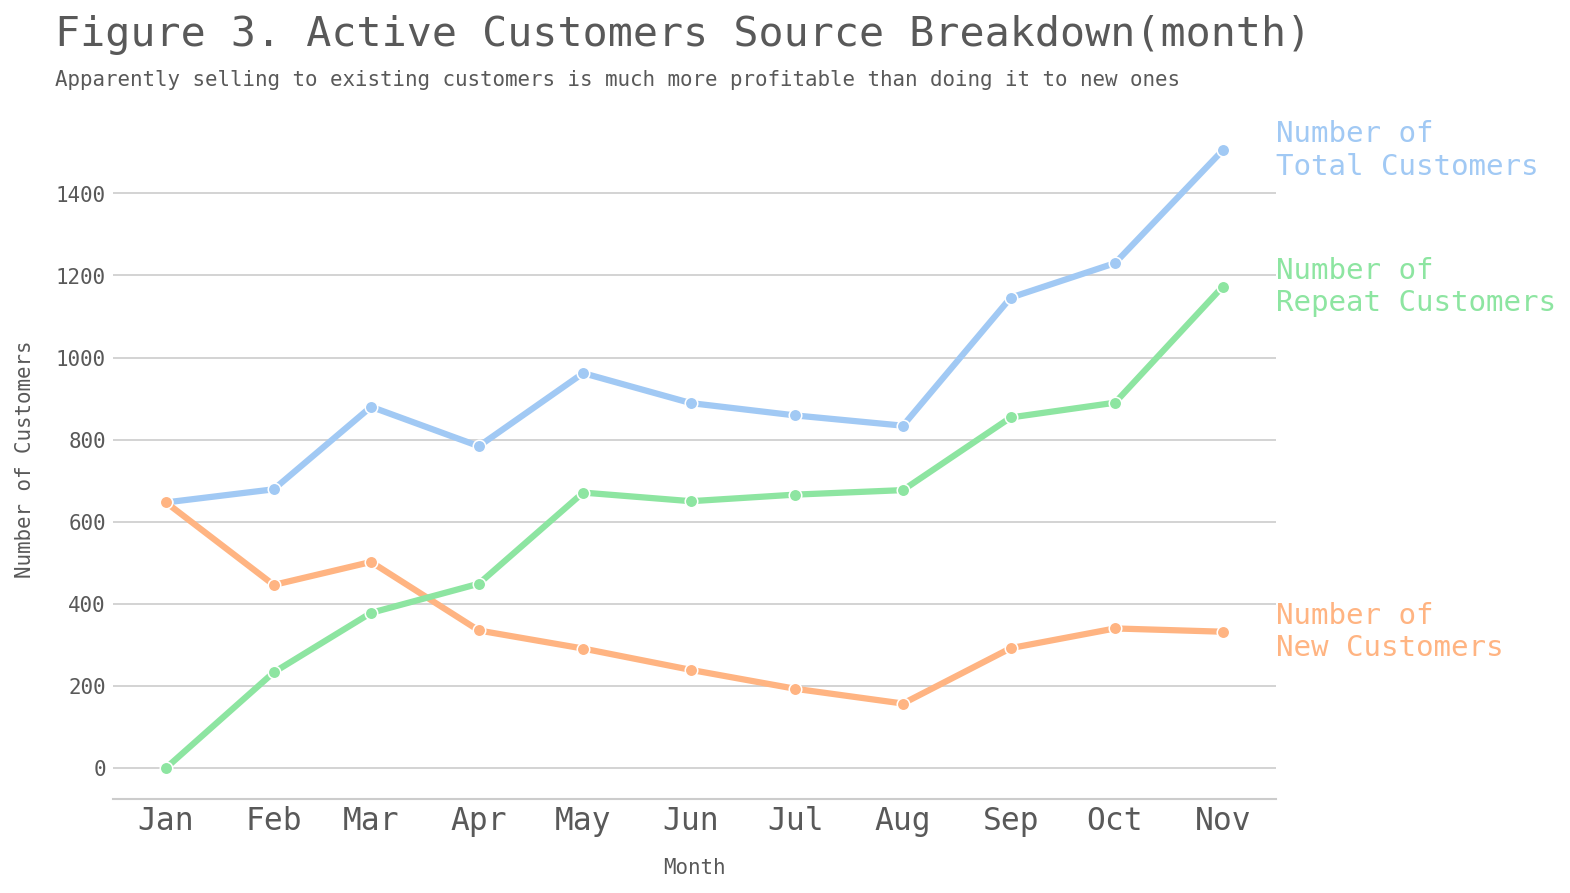

In [49]:
# Customers revenue by month
warnings.filterwarnings("ignore")
plot_style_setting(figsize=[10, 6])
monthly_cus_df_melt = monthly_cus_df.melt(id_vars='InvoiceDay', 
                                          value_vars=['TotalCustomers', 'NumberOfNewCustomers', 'NumberOfRepeatCustomers'],
                                          var_name='Type') 
g4 = sns.lineplot(x="InvoiceDay", 
                 y="value", 
                 hue="Type", 
                 lw=3, 
                 marker='o',
                 palette = 'pastel',
                 data=monthly_cus_df_melt)

for l, name in zip(g4.lines, ['Number of\nTotal Customers', 'Number of\nNew Customers', 'Number of\nRepeat Customers']):
    y = l.get_ydata()
    if len(y)>0:
        g4.annotate(f'{name}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color(), fontsize=14)


g4.set_xticklabels([i for i in calendar.month_abbr][1:12], fontsize=15)
plt.title('Figure 3. Active Customers Source Breakdown(month)', fontsize=20, x=0.49, y=1.09)
plt.text(-0.05, 1.05, 
         f'Apparently selling to existing customers is much more profitable than doing it to new ones', 
         transform=g4.transAxes)
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.legend().remove()
sns.despine(left=True)


Having new customers is always a good thing to know. However, to maximize the profits, we want to have repeat customers and recurring customers (in contractual business). These customers are those who are not only loyal to your business, but they also are more likely to refer new customers, which is often called advocacy marketing. As is shown in the graph above, the majority of customer during the sales boost from August to November is repeat customer (existing customer) and the gap between the number of existing and new customer continues to widen. 

In [15]:
# Total Revenue per month 
monthly_rev_df = online_df.groupby('InvoiceDay', as_index=False)['Revenue']\
                          .sum()\
                          .rename({'Revenue': 'MonthlyRevenue'}, axis=1)

# Separate revenue of new customers and exsisting customers from total revenue
monthly_rev_df['RevenueOfNewCustomers'] = online_df.loc[online_df['InvoiceDay'] == online_df['FirstPurchMonth']].groupby('FirstPurchMonth')['Revenue'].sum().tolist()
monthly_rev_df['RevenueOfRepeatCustomers'] = monthly_rev_df['MonthlyRevenue'] - monthly_rev_df['RevenueOfNewCustomers']

In [16]:
# Separate revenue of new customers and exsisting customers from total revenue
monthly_rev_df['RevenueOfNewCustomersAvg'] = online_df.loc[online_df['InvoiceDay'] == online_df['FirstPurchMonth']].groupby('FirstPurchMonth')['Revenue'].mean().tolist()
monthly_rev_df['RevenueOfRepeatCustomersAvg'] = monthly_rev_df['MonthlyRevenue'] - monthly_rev_df['RevenueOfNewCustomers']

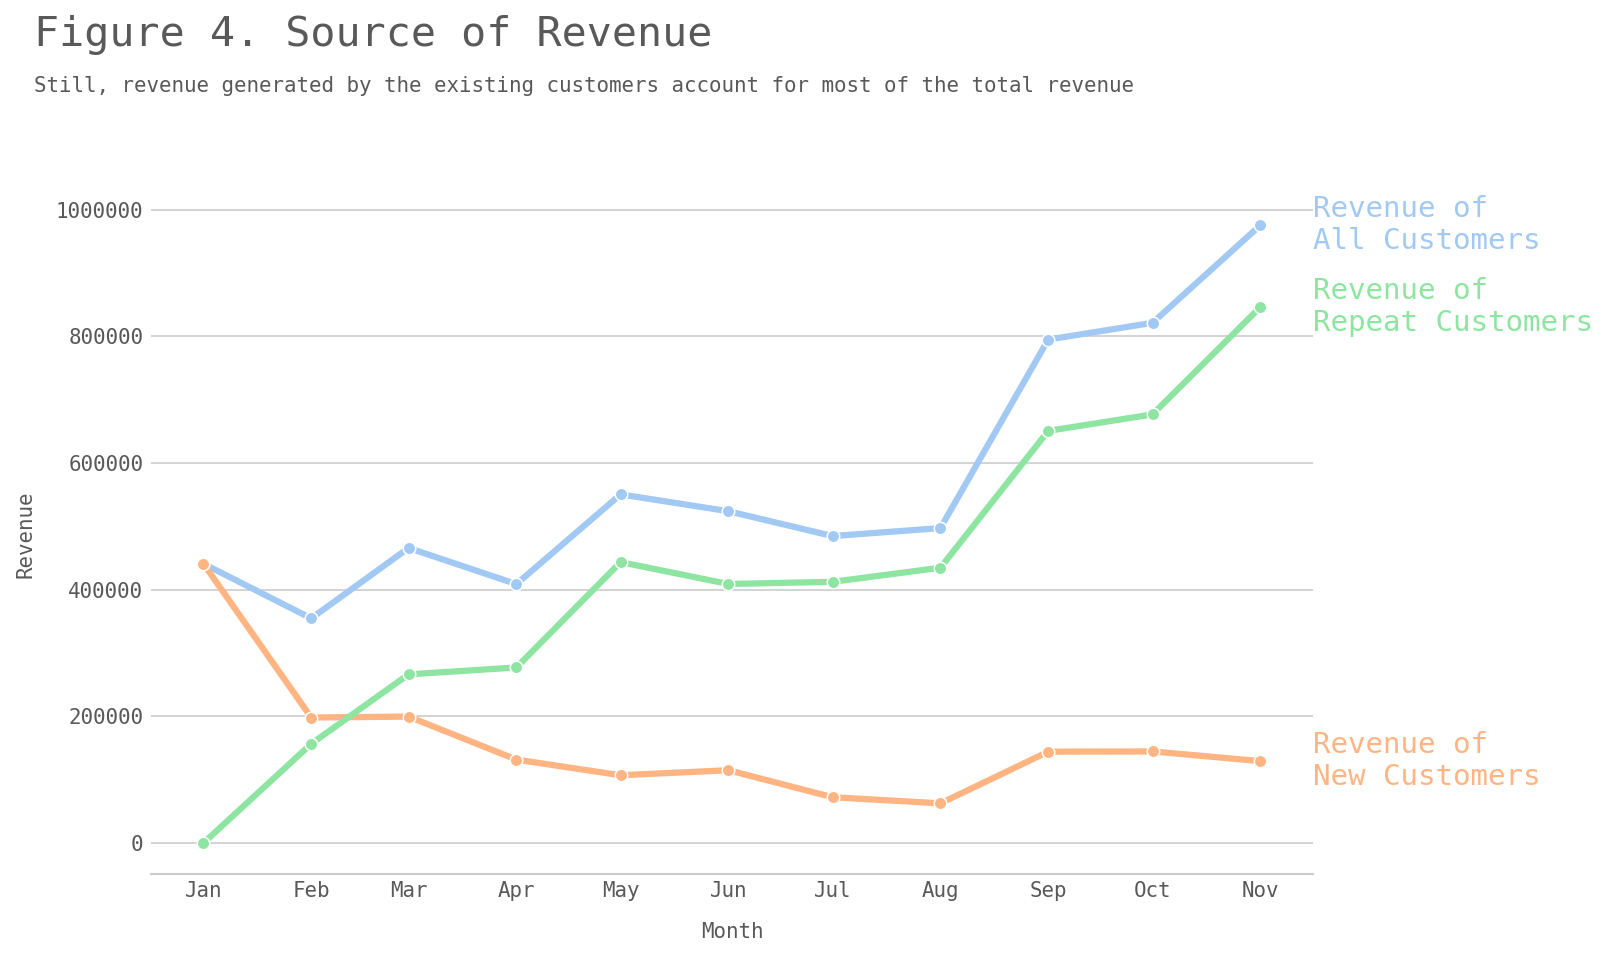

In [17]:
# Customers revenue by month
warnings.filterwarnings("ignore")
monthly_rev_df_melt = monthly_rev_df.melt(id_vars='InvoiceDay', 
                                          value_vars=['MonthlyRevenue', 'RevenueOfNewCustomers', 'RevenueOfRepeatCustomers'],
                                          var_name='Type') 

plot_style_setting()
g5 = sns.lineplot(x="InvoiceDay", 
                 y="value", 
                 hue="Type", 
                 lw=3, 
                 marker='o',
                 palette = 'pastel',
                 data=monthly_rev_df_melt)

for l, name in zip(g5.lines, [f'Revenue of\nAll Customers', 'Revenue of\nNew Customers', 'Revenue of\nRepeat Customers']):
    y = l.get_ydata()
    if len(y)>0:
        g5.annotate(f'{name}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color(), fontsize=14)

g5.set_xticklabels([i for i in calendar.month_abbr][1:12])
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
g5.yaxis.set_major_formatter(formatter)

plt.title(f'Figure 4. Source of Revenue', 
          fontsize=20, 
          color='#595959',
          loc='left',
          x=-0.1,
          y=1.2)
plt.text(-0.1, 1.15, f'Still, revenue generated by the existing customers account for most of the total revenue', transform=g5.transAxes)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend().remove()

sns.despine(left=True)


From Figure 4, we see that clearly most of the revenue of the store comes from repeat customers over months with line of revenue from new customers staying fairly flat. The result further prove our statement from previous graph. For now we know that perhaps a marketing campaign targeting the repeat customer was implemented or a loyal program as well as some sort of reward system was developed. The credibility of the latter guess could be tested later on in the cohort analysis. 

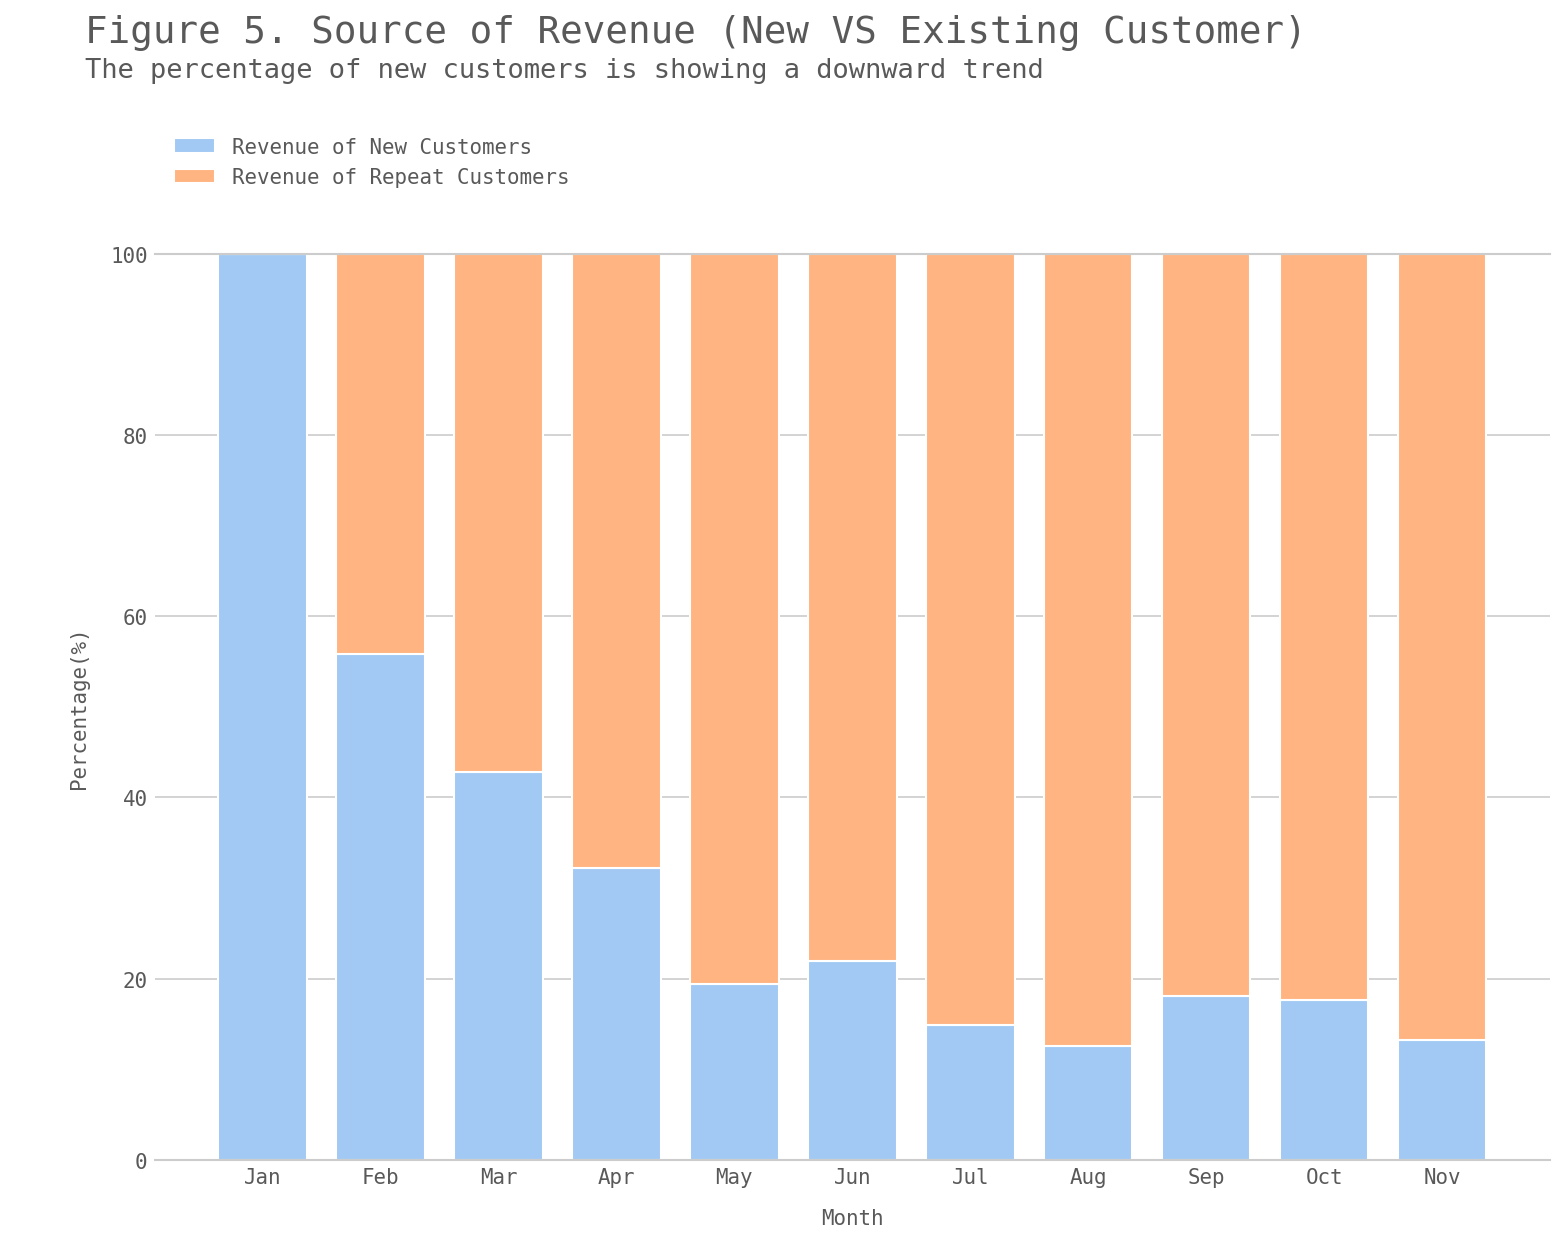

In [20]:
# From raw value to percentage
time_range = np.arange(monthly_rev_df.shape[0])
RevenueOfNewCustomers = [i / j * 100 for i,j in zip(monthly_rev_df['RevenueOfNewCustomers'], monthly_rev_df['MonthlyRevenue'])]
RevenueOfRepeatCustomers = [i / j * 100 for i,j in zip(monthly_rev_df['RevenueOfRepeatCustomers'], monthly_rev_df['MonthlyRevenue'])]
 
# plot
barWidth = 0.75
plt.bar(time_range, RevenueOfNewCustomers, color='#a1c9f4', edgecolor='white', width=barWidth, label='Revenue of New Customers')
plt.bar(time_range, RevenueOfRepeatCustomers, bottom=RevenueOfNewCustomers, color='#ffb482', edgecolor='white', width=barWidth, label='Revenue of Repeat Customers')
 
plt.xticks(time_range, [i for i in calendar.month_abbr][1:12])
plt.xlabel("Month")
plt.ylabel("Percentage(%)")
plt.title(f'Figure 5. Source of Revenue (New VS Existing Customer)', 
          fontsize=18, 
          color='#595959',
          loc='left',
          x=-0.05,
          y=1.22)
plt.text(-0.088, 1.55, f'The percentage of new customers is showing a downward trend', 
         transform=g5.transAxes,
         fontsize=13)
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15)) 
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()


We know that the revenue brought by the existing customers is way higher than that by the new customers, which can be observed from both Figure 4 and 5. Some people may say that it not at all fair because the number of new comers is fewer than that of the existing ones. To address this question, I would like to look into the individual contribution, in this case, average unit price.

In [21]:
# Prepare the data
AvgUnitpriceNewCus = online_df.loc[online_df['InvoiceDay'] == online_df['FirstPurchMonth']].groupby('InvoiceDay')['UnitPrice'].mean()
AvgUnitpriceRepCus = online_df.loc[online_df['InvoiceDay'] != online_df['FirstPurchMonth']].groupby('InvoiceDay')['UnitPrice'].mean()
AvgUnitprice_df = pd.DataFrame([AvgUnitpriceNewCus, AvgUnitpriceRepCus]).T.reset_index()
AvgUnitprice_df.columns = ['Month', 'AvgUnitpriceNewCus', 'AvgUnitpriceRepCus']

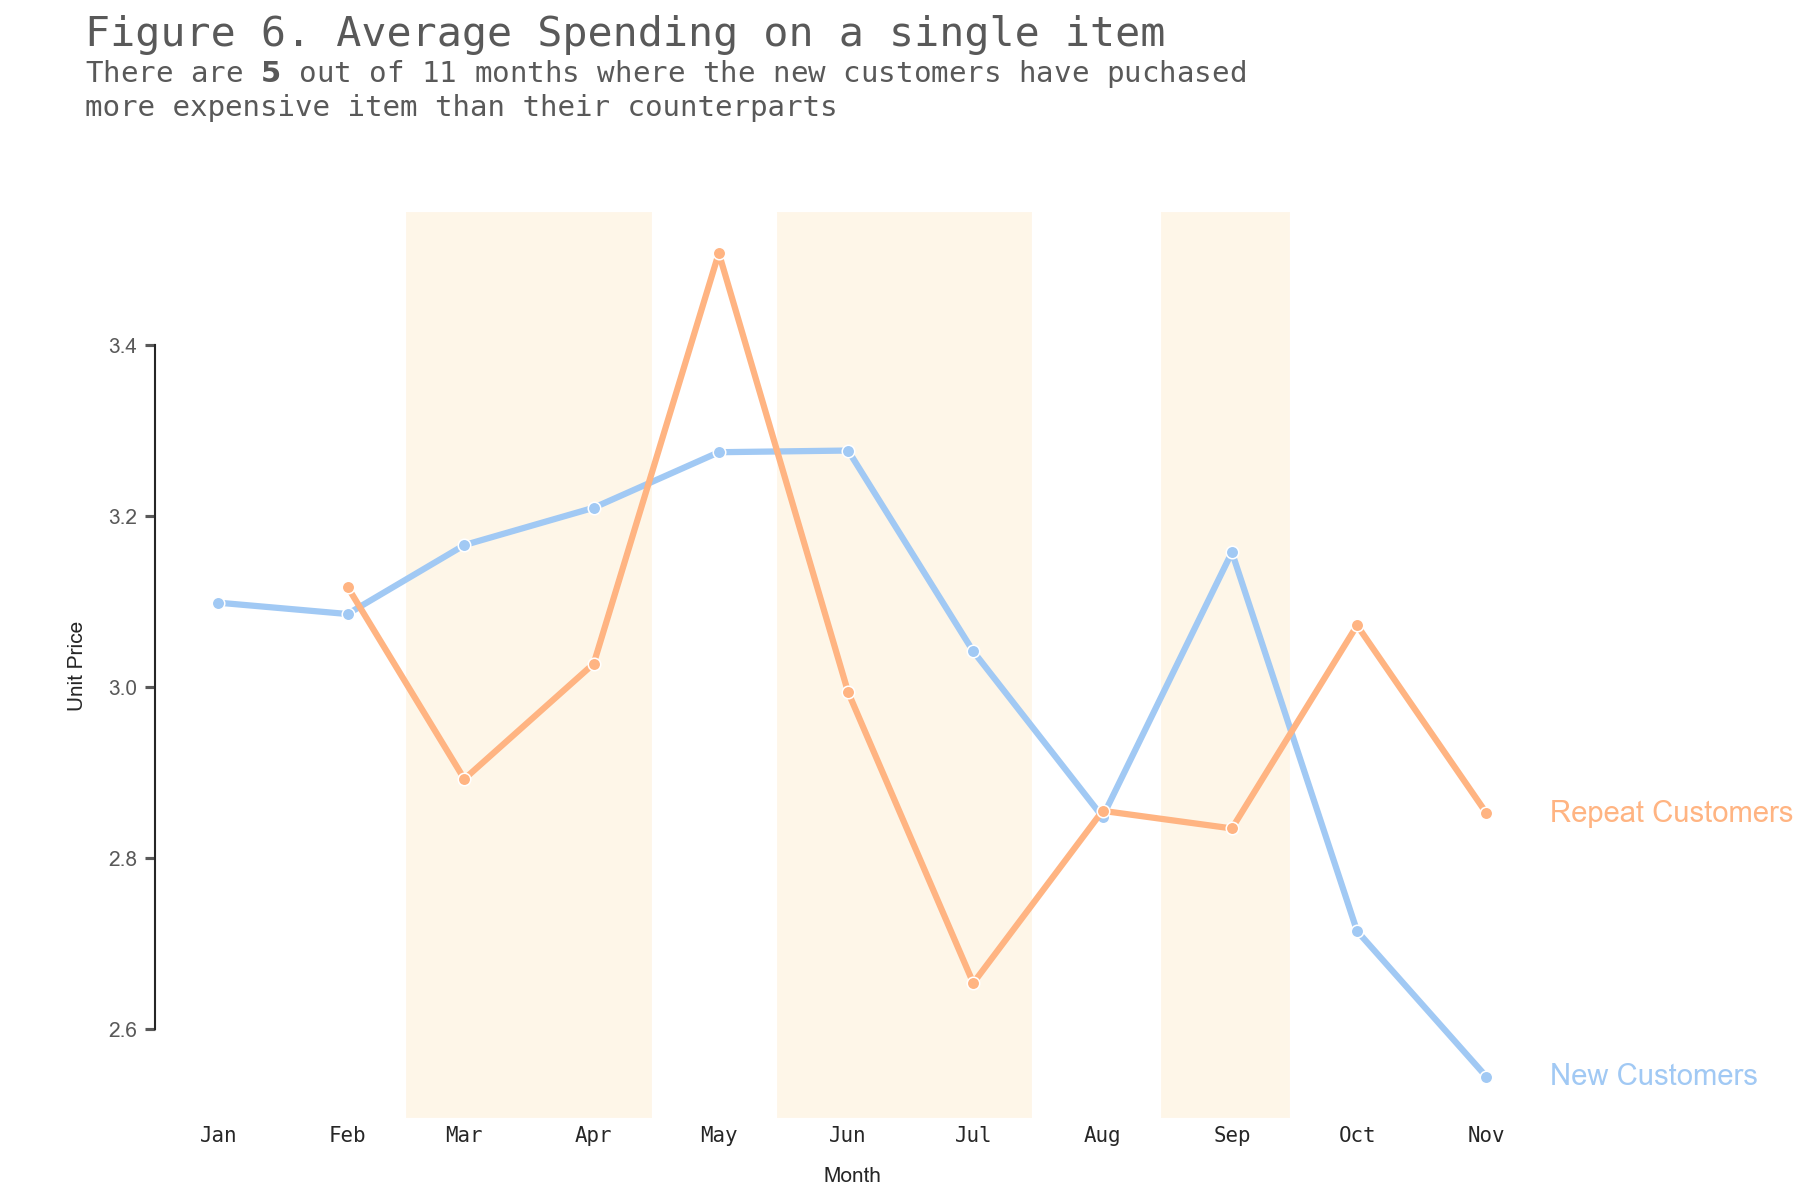

In [22]:
# Plot the result
AvgUnitprice_df_melt = AvgUnitprice_df.melt('Month', ['AvgUnitpriceNewCus', 'AvgUnitpriceRepCus'], var_name='type')

sns.set_style('ticks')

g7 = sns.lineplot(x="Month", 
                  y="value", 
                  hue="type",
                  lw=3,
                  marker='o',
                  palette = 'pastel',
                  data=AvgUnitprice_df_melt)

for l, name in zip(g7.lines, ['New Customers', 'Repeat Customers']):
    y = l.get_ydata()
    if len(y)>0:
        g7.annotate(f'{name}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color(), fontsize=14)

g7.set_xticklabels([i for i in calendar.month_abbr][1:12], fontname='monospace')

# Highlight
plt.axvspan('2011-02-15', '2011-04-15', facecolor='#f7b025', alpha=0.1)
plt.axvspan('2011-05-15', '2011-07-15', facecolor='#f7b025', alpha=0.1)
plt.axvspan('2011-08-15', '2011-09-15', facecolor='#f7b025', alpha=0.1)

plt.tick_params(axis='y', length=5, width=1.5, colors='#595959')


plt.title('Figure 6. Average Spending on a single item', 
          fontsize=20, 
          color='#595959',
          loc='left',
          x=-0.05,
          y=1.17,
          fontname='monospace')
bold_n = r"$\bf{" + str(5) + "}$"
plt.text(-0.088, 1.43, f'There are {bold_n} out of 11 months where the new customers have puchased\nmore expensive item than their counterparts', 
         transform=g5.transAxes,
         fontsize=14,
         color='#595959',
         fontname='monospace')
plt.xlabel("Month")
plt.ylabel("Unit Price")

plt.legend().remove()
sns.despine(bottom=True, trim=True)

We see from the Figure 6 that in nearly half of the year, the new customers have a higher average number in terms of the price of unit item. It is of course inclusive to say that the new customers are therefore valuable to the store based on this single result. What we can draw from the figure is that although the new customers don't generate as much revenue and account for less proportion in our customer base, they are still important and are our potential cash cow. Imagine if we can increase the number of new comers each month (at a low cost) and also their quantity bought in each transaction. 

# Cohort Analysis

From previous analysis, we know that the efficiency of customer retention efforts is hard to underestimate. With 80% of the future profits coming from 20% of existing customers, the ability to keep them loyal is the key to success. Performing a proper cohort analysis can help isolate the impact of your different marketing activities on a specific group of recipients, instead of noise in the data. a cohort usually refers to a subset of users specifically segmented by acquisition date (i.e. the first time a user visits your website). In this project, we will assume that the date that a customer made his or her first purchase is the acquisition date.

In [23]:
# Define a function that gets the integers for date parts from the certain column
def get_date_int(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [28]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online_df, 'InvoiceDay')

# Get the integers for date parts from the `FirstPurchMonth` column
cohort_year, cohort_month, cohort_day = get_date_int(online_df, 'FirstPurchMonth')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# add 1 for better interpretation
online_df['CohortIndex'] = years_diff * 12 + months_diff 
online_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,DayOfWeek,Revenue,InvoiceDay,FirstPurchMonth,LastPurchMonth,DurationMonth,CohortIndex
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,2011,1,Tuesday,19.5,2011-01-01,2011-01-01,2011-11-01,10,0
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,2011,1,Tuesday,10.5,2011-01-01,2011-01-01,2011-11-01,10,0
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,2011,1,Tuesday,10.5,2011-01-01,2011-01-01,2011-11-01,10,0
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,2011,1,Tuesday,10.5,2011-01-01,2011-01-01,2011-11-01,10,0
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,2011,1,Tuesday,12.5,2011-01-01,2011-01-01,2011-11-01,10,0


In [29]:
# Count the number of unique values per customer ID
cohort_data = online_df.groupby(['FirstPurchMonth', 'CohortIndex'])['CustomerID']\
                       .apply(pd.Series.nunique)\
                       .reset_index()\
                       .rename({'CustomerID': 'Count'}, axis=1)
cohort_data.CohortIndex = cohort_data.CohortIndex.apply(lambda x:int(x))
cohort_data.head()

,FirstPurchMonth,CohortIndex,Count
0,2011-01-01,0,647
1,2011-01-01,1,233
2,2011-01-01,2,276
3,2011-01-01,3,255
4,2011-01-01,4,304


## Customer Retention

In [30]:
# Create a pivot 
cohort_counts = cohort_data.pivot(index='FirstPurchMonth', columns='CohortIndex', values='Count')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention_df = cohort_counts.divide(cohort_sizes, axis=0)
retention_df.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10
FirstPurchMonth,,,,,,,,,,,
2011-01-01,1.0,0.360124,0.426584,0.394127,0.469861,0.415765,0.395672,0.394127,0.449768,0.412674,0.513138
2011-02-01,1.0,0.228700,0.248879,0.340807,0.320628,0.271300,0.302691,0.331839,0.322870,0.360987,NaN
2011-03-01,1.0,0.165339,0.272908,0.225100,0.227092,0.185259,0.282869,0.241036,0.306773,NaN,NaN
2011-04-01,1.0,0.232836,0.217910,0.241791,0.217910,0.229851,0.247761,0.298507,NaN,NaN,NaN
2011-05-01,1.0,0.178694,0.175258,0.182131,0.219931,0.237113,0.278351,NaN,NaN,NaN,NaN


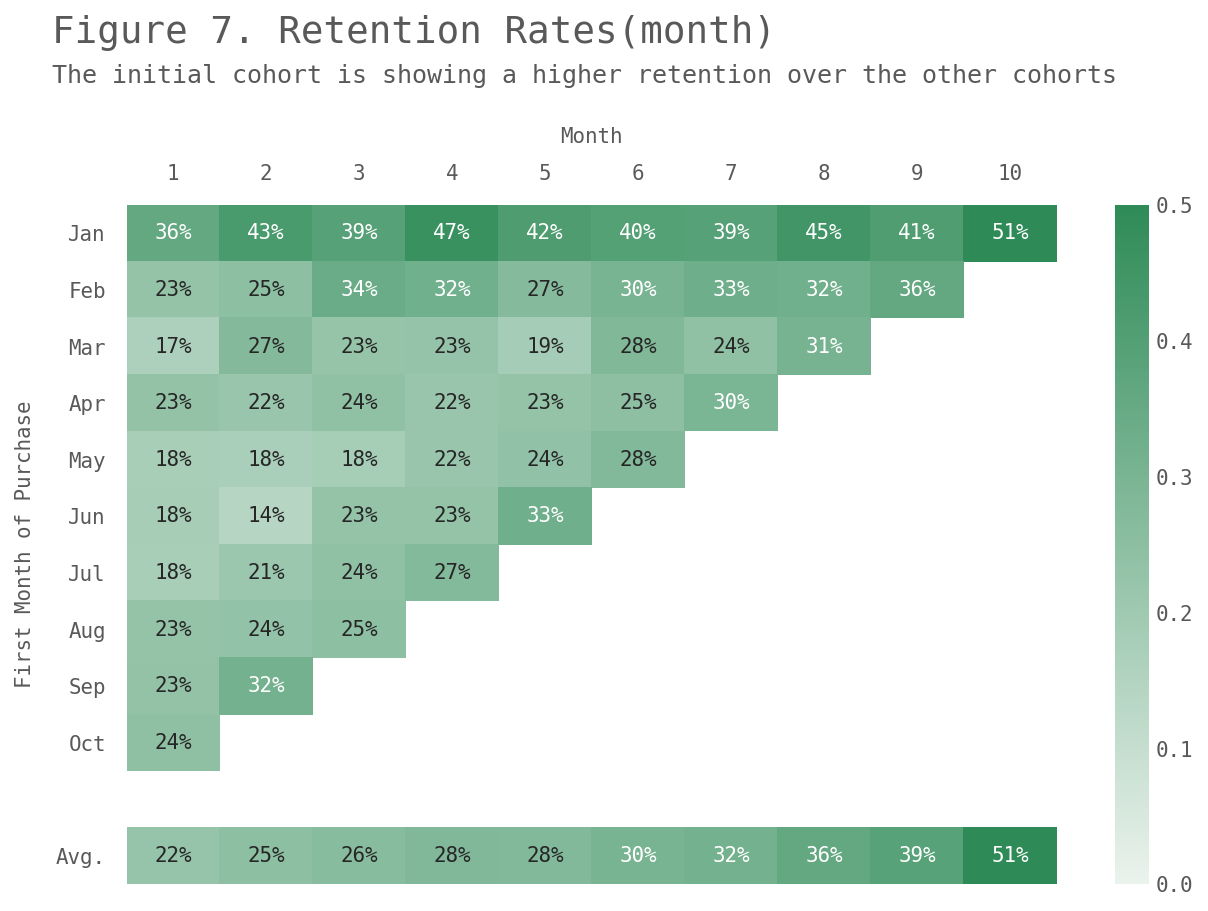

In [39]:
# Plot the heatmap using seaborn
retention_df.index = retention_df.index.astype('str')
retention_df.loc['Avg'] = retention_df.mean(axis=0)

plot_style_setting()
g8 = sns.heatmap(retention_df.iloc[:, 1:], 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0, 
            vmax = 0.5,
            cmap=sns.light_palette('seagreen', as_cmap=True))

plt.title('Figure 7. Retention Rates(month)', 
          x=-0.08,
          y=1.22,
          fontsize=18,
          loc='left')
plt.text(-0.08, 1.18, f'The initial cohort is showing a higher retention over the other cohorts', 
         transform=g8.transAxes,
         fontsize=12)
plt.xlabel('Month')
plt.ylabel('First Month of Purchase')
g8.xaxis.set_ticks_position('top')
g8.xaxis.set_label_position('top')
plt.tick_params(axis='both', pad=10)
plt.yticks(g8.get_xticks().tolist() + [11.5], [i for i in calendar.month_abbr][1:11] + ['Avg.'])

plt.show() 

For those who are not familiar with this, if you read the chart above horizontally, you can see how your retention develops over the customer lifetime, presumably something that you can link to the quality of your product or marketing campaigns. Reading it vertically shows you the retention at a given lifetime month for different customer cohorts. 

There are 2 findings here:
1. The first cohort(the group of customers who came to the store in January) has a higher retention than all the other cohorts.
2. Interestingly, the retention rate in each cohort is gradually increasing over months, which is reflected on the average retention rate(at the bottom of the graph).

## Average Spending Per Transaction

Besides retention, we can also switch gear to look at another metric, average spending.

In [34]:
cohort_data_price = online_df.groupby(['FirstPurchMonth', 'CohortIndex'])['Revenue'].mean().reset_index()
average_spending_df = cohort_data_price.pivot(index='FirstPurchMonth', columns='CohortIndex', values='Revenue').round(2)
average_spending_df.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,10
FirstPurchMonth,,,,,,,,,,,
2011-01-01,24.61,22.49,22.53,23.17,24.43,23.16,23.21,22.96,28.26,23.20,20.95
2011-02-01,18.72,26.47,22.25,25.11,30.85,26.99,29.67,34.50,37.84,28.83,NaN
2011-03-01,16.30,19.81,21.25,16.37,18.67,19.68,17.68,19.39,15.09,NaN,NaN
2011-04-01,15.80,18.66,17.05,17.20,18.29,13.81,15.01,18.02,NaN,NaN,NaN
2011-05-01,17.60,17.27,20.08,20.24,18.30,13.16,16.73,NaN,NaN,NaN,NaN


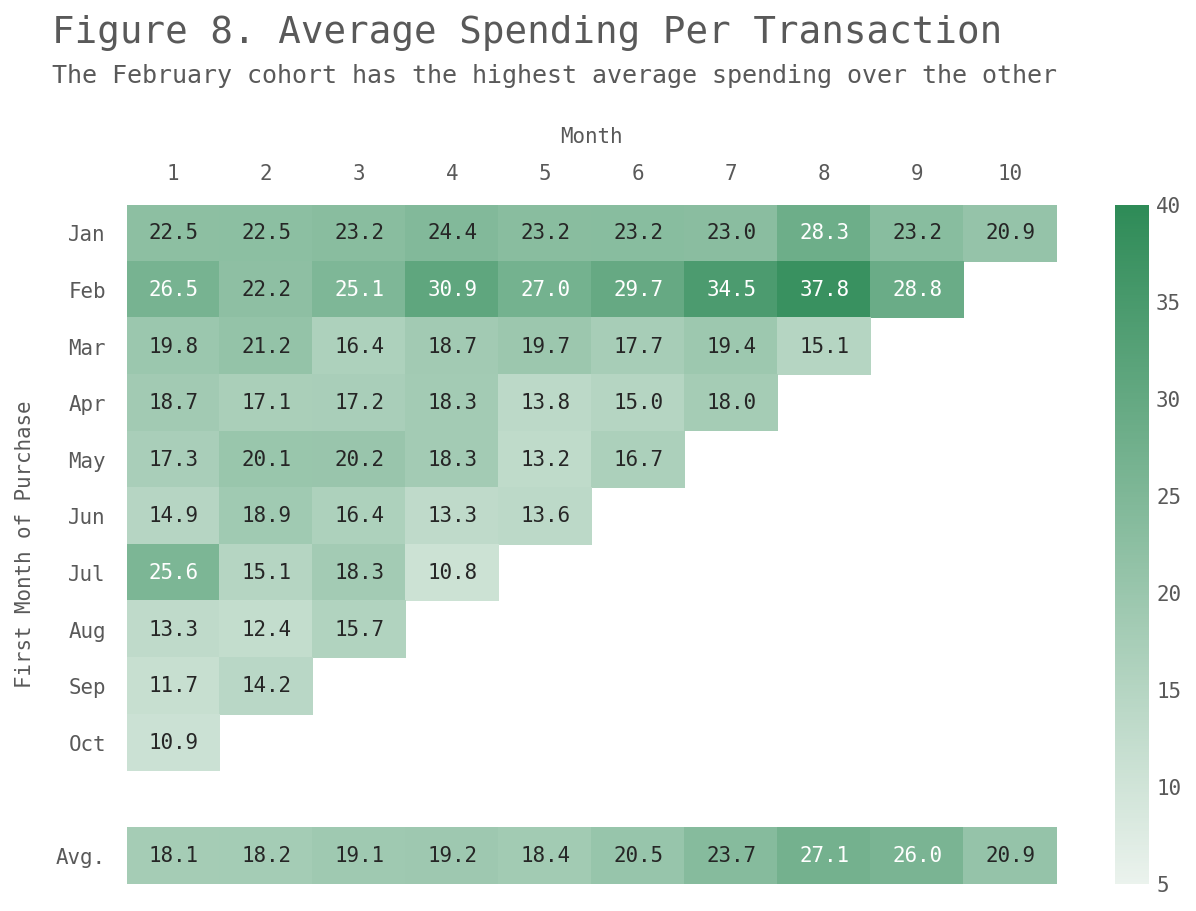

In [38]:
average_spending_df.index = average_spending_df.index.astype('str')
average_spending_df.loc['Avg'] = average_spending_df.mean(axis=0)

plot_style_setting()
g9 = sns.heatmap(average_spending_df.iloc[:, 1:], 
            annot = True,
            vmin = 5,
            vmax = 40,
            fmt = '.3', 
            cmap=sns.light_palette('seagreen', as_cmap=True))

plt.xlabel('Month')
plt.ylabel('First Month of Purchase')
plt.title('Figure 8. Average Spending Per Transaction', 
          fontsize=18,
          x=-0.08,
          y=1.22,
          loc='left')
plt.text(-0.08, 1.18, f'The February cohort has the highest average spending over the other', 
         transform=g9.transAxes,
         fontsize=12)

plt.xlabel('Month')
plt.ylabel('First Month of Purchase')
g9.xaxis.set_ticks_position('top')
g9.xaxis.set_label_position('top')
plt.tick_params(axis='both', pad=10)
plt.yticks(g9.get_xticks().tolist() + [11.5], [i for i in calendar.month_abbr][1:11] + ['Avg.'])
plt.show() 

From figure 9, we notice that the February cohort has the highest average spending over the other. Also, the average spending is slightly higher in August. It's worth looking into the February cohort by examining not only the shopping patterns but also the categories and items they are buying.

## Average Spending Per Customer

In [40]:
cohort_avg_spending = online_df.groupby(['FirstPurchMonth', 'CohortIndex'])['Revenue'].sum().reset_index()
average_spending_cus = cohort_avg_spending.pivot(index='FirstPurchMonth', columns='CohortIndex', values='Revenue')
average_spending_cus_df = average_spending_cus.divide(cohort_counts)
average_spending_cus_df

CohortIndex,0,1,2,3,4,5,6,7,8,9,10
FirstPurchMonth,,,,,,,,,,,
2011-01-01,681.416275,671.893562,770.799130,697.608235,825.831184,787.168141,839.966875,832.403922,1082.133887,950.444831,1102.995271
2011-02-01,444.096413,524.409020,583.499910,602.226908,721.814895,665.259504,736.763185,955.855000,1191.488889,809.847888,NaN
2011-03-01,397.517749,414.793133,494.852190,421.257345,470.612018,534.155806,490.442887,637.373388,544.415390,NaN,NaN
2011-04-01,392.975197,423.770128,388.900137,371.380000,426.420274,406.815584,460.216988,560.809000,NaN,NaN,NaN
2011-05-01,367.420481,344.710385,368.874314,377.300566,464.628906,420.042754,421.468272,NaN,NaN,NaN,NaN
2011-06-01,480.715900,331.172093,318.235588,411.104000,404.355818,444.088974,NaN,NaN,NaN,NaN,NaN
2011-07-01,374.264927,331.249706,485.598780,524.966739,369.615849,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,398.625987,584.125833,912.100811,1111.390513,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,493.775860,395.447059,420.935000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


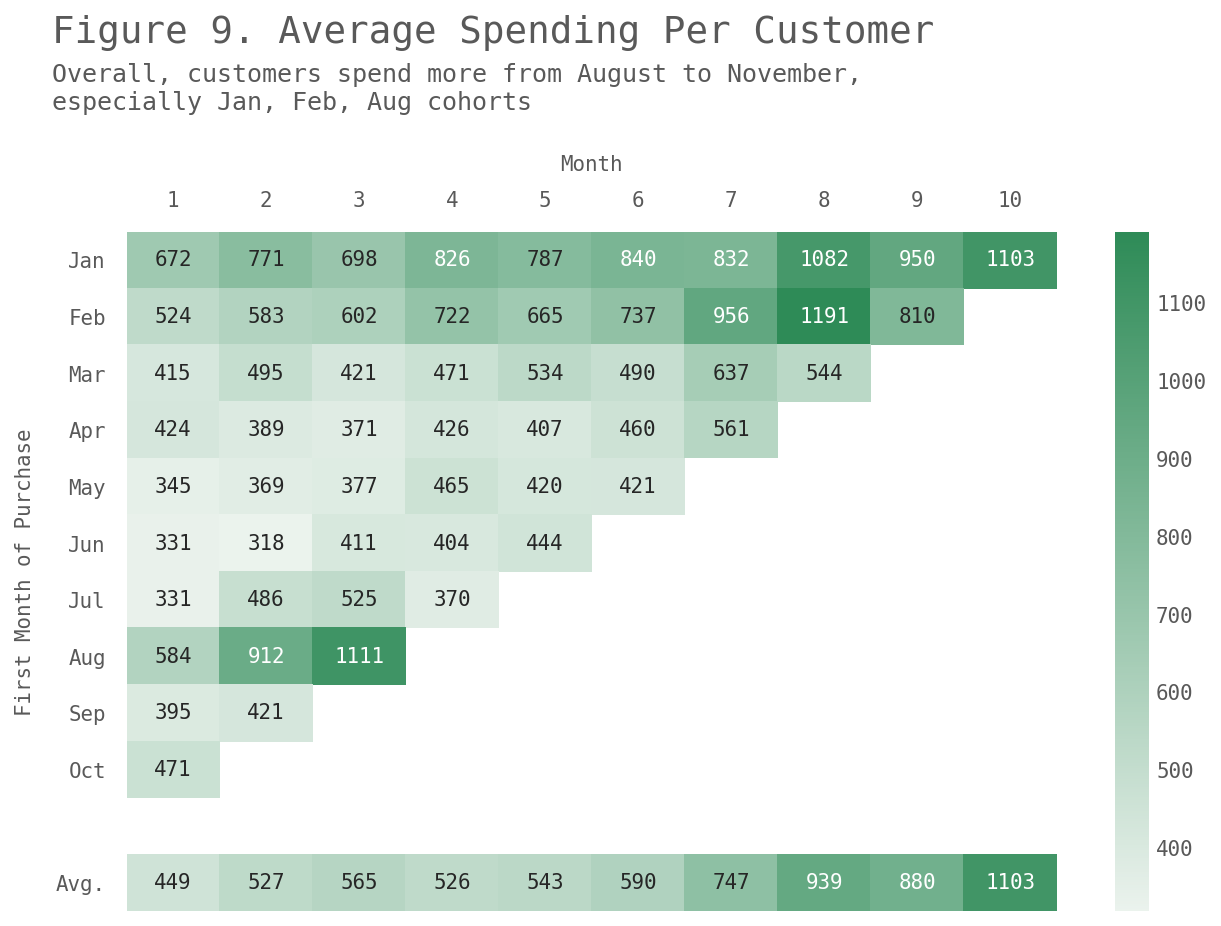

In [42]:
average_spending_cus_df.index = average_spending_cus_df.index.astype('str')
average_spending_cus_df.loc['Avg'] = average_spending_cus_df.mean(axis=0)

plot_style_setting()
g10 = sns.heatmap(average_spending_cus_df.iloc[:, 1:], 
            annot = True,
            annot_kws={'fontsize':10},
            fmt='.0f',
            cmap=sns.light_palette('seagreen', as_cmap=True))

plt.xlabel('Month')
plt.ylabel('First Month of Purchase')
plt.title('Figure 9. Average Spending Per Customer', 
          x=-0.08,
          y=1.26,
          fontsize=18,
          loc='left')
plt.text(-0.08, 1.18, f'Overall, customers spend more from August to November,\nespecially Jan, Feb, Aug cohorts', 
         transform=g10.transAxes,
         fontsize=12)

plt.xlabel('Month')
plt.ylabel('First Month of Purchase')
g10.xaxis.set_ticks_position('top')
g10.xaxis.set_label_position('top')
plt.tick_params(axis='both', pad=10)
plt.yticks(g10.get_xticks().tolist() + [11.5], [i for i in calendar.month_abbr][1:11] + ['Avg.'])
plt.show() 

Figure 9 provides a strong evidence that what cohorts are the main contributers of the surge in revenue starting from September(see figure 1). We see that the January, February, and August cohorts are likely to be the direct answer to the spike in sales from September. By analyzing and these groups, we can better understand what sets these customer different from others and develop a customized targeting strategy toward these potential high-quality leads that can add value to the company.

# Customer Life Time Value

In this project I will be using traditional CLV model which covers all possible changes in retention during a particular period and the customer life expectation is inferred from the retention to churn ratio. Note that this model assumes that the churn is final. Customers who don't come back the next month are not coming back ever after.

In [44]:
# Calculate monthly spend per customer
monthly_rev_cus = online_df.groupby(['CustomerID', 'InvoiceDay'], as_index=False)['Revenue']\
                           .sum()\
                           .groupby(['CustomerID'])['Revenue']\
                           .mean() 

# Calculate average monthly retention rate
retention_rate = retention_df.drop('Avg', axis=0).mean().mean()

# Calculate average monthly churn 
churn_rate = 1 - retention_rate

# Calculate traditional CLV 
# We’ll take a standard 10% discount rate.
discount_rate = 0.1
clv_traditional = monthly_rev_cus * (retention_rate / churn_rate + discount_rate)

# Get the median of the CLV values
median_clv = clv_traditional.median()

# Put the CLV values back to the data frame
online_df = online_df.merge(clv_traditional.to_frame().reset_index().rename({'Revenue':'clv_traditional'}, axis=1), 
                            on='CustomerID')

In [45]:
online_df.loc[(online_df.clv_traditional>=median_clv) & (online_df.FirstPurchMonth.isin(['2011-08-01', '2011-02-01', '2011-01-01']))].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,DayOfWeek,Revenue,InvoiceDay,FirstPurchMonth,LastPurchMonth,DurationMonth,CohortIndex,clv_traditional
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,2011,1,Tuesday,19.5,2011-01-01,2011-01-01,2011-11-01,10,0,276.309473
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,2011,1,Tuesday,10.5,2011-01-01,2011-01-01,2011-11-01,10,0,276.309473
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,2011,1,Tuesday,10.5,2011-01-01,2011-01-01,2011-11-01,10,0,276.309473
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,2011,1,Tuesday,10.5,2011-01-01,2011-01-01,2011-11-01,10,0,276.309473
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,2011,1,Tuesday,12.5,2011-01-01,2011-01-01,2011-11-01,10,0,276.309473


# Conclusion

Now we have know make our targeting strategy more accurate by taking into account the customer lifetime value. For example, customer in the January cohort with lifetime value higher than the median lifetime value (or any threshold that makes sense) of total customers may be worth putting more attention to. Company may consider upsell and cross-sell to these existing customers and personalizing future marketing activities to potentially find new customers. I would like to share a strategy that I drawn from my work experience at Xiaohongshu. If you want to increase sales from those profitable customers and if you are offering free shipping, consider setting your discount threshold higher. Depending on the categories, average price of the products, and also the customer shopping behavior, the threshold should vary. If your customers typically come close to reaching the threshold you set, they kind of tend to justify tossing an extra item in their cart to get the free shipping reward.

Note that measuring and improving CLV is not the only thing necessary to grow the business. Another key factor to look at in conjunction for CLV is the customer acquisition cost(CAC). Increasing your CLV and reducing your CAC to reach an optimal CLV:CAC ratio of 3:1. In the real case, we would also need to understand the difference between being a contractual and non-contractual business when it comes to customer lifespan. Most online stores are non-contractual like in this case, meaning that once a purchase is made, the transaction is effectively over. The difficulty with these types of businesses is in identifying when an active customer (someone who makes purchases and will continue to make purchases) becomes an inactive customer who never come back. Defining a reasonable metric is hence a important task for a company. From my perspective, a company should develop the metric based on the analysis of customer shopping pattern in the store and modify the metric over time.